In [105]:
import pandas as pd
import os
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from copy import deepcopy

def scale_min_max(ser, minimum=-1, maximum=1):
    ser_min = ser.min()
    ser_max = ser.max()
    return minimum + ((maximum-minimum)*(ser-ser_min))/(ser_max-ser_min)

def compute_fft_aggregate(sig):
    scaled = scale_min_max(sig)
    ac_component = scaled - scaled.mean()
    return np.fft.fft(ac_component)

def decompose(df, freq=96):
    res = sm.tsa.seasonal_decompose(df.fillna(method='ffill').values, freq=freq)
    return pd.DataFrame({"seasonal":res.seasonal, "trend":res.trend, "obs":res.observed}, index=df.index)


In [106]:
st = pd.HDFStore(os.path.expanduser("/Users/nipunbatra/wiki-all.h5"))

In [107]:
metadata_df = pd.read_csv("/Users/nipunbatra/w/dataport-metadata.csv",index_col=0)

In [108]:
sd_data = metadata_df[metadata_df['city'] == "San Diego"]

In [109]:
sd_homes = sd_data.index.values.astype('int')

In [115]:
months=3
start='7-1-2014'
start_month=7
end = '9-30-2014'
end_month=10

In [129]:
to_ignore = [5909, 6268, 6689, 527, 1524, 2031, 4761, 6497, 9836, 4329, 8886]

In [130]:
out = {}
for home in sd_homes[:]:
    if home in to_ignore:
        continue
    try:
        data_df = st['/%d' %home][start:end]
        data_df_resampled = data_df.resample("1M", how="sum")
        df_res_kwh = data_df_resampled.div(1000)
        fridge = np.array([np.NaN]*3)
        hvac = np.array([np.NaN]*3)
        dw = np.array([np.NaN]*3)
        mw = np.array([np.NaN]*3)
        aggregate = np.array([np.NaN]*3)

        if "refrigerator1" in df_res_kwh.columns:
            fridge = df_res_kwh['refrigerator1'].squeeze().values
        if 'air1' in df_res_kwh.columns:
            hvac = df_res_kwh['air1'].squeeze().values
        if 'dishwasher1' in df_res_kwh.columns:
            dw = df_res_kwh['dishwasher1'].squeeze().values
        if 'microwave1' in df_res_kwh.columns:
            mw = df_res_kwh['microwave1'].squeeze().values
        
    
        aggregate = df_res_kwh["use"].values

        out[home] = np.hstack([aggregate, hvac, fridge, dw, mw])
    except:
        pass
    

In [131]:
{x:len(out[x]) for x in out}

{54: 15,
 203: 15,
 1450: 15,
 1731: 15,
 2354: 15,
 2606: 15,
 3687: 15,
 3864: 15,
 3938: 15,
 4083: 15,
 4095: 15,
 4495: 15,
 4934: 15,
 5938: 15,
 6377: 15,
 6429: 15,
 6547: 15,
 7062: 15,
 7114: 15,
 7409: 15,
 7639: 15,
 8061: 15,
 8342: 15,
 8574: 15,
 8733: 15,
 9213: 15,
 9370: 15,
 9585: 15,
 9612: 15,
 9775: 15}

In [180]:
df = pd.DataFrame(out).T
df.columns=np.hstack([['aggregate_%d' %month for month in range(start_month,end_month)],
                          ['hvac_%d' %month for month in range(start_month,end_month)],
                          ['fridge_%d' %month for month in range(start_month,end_month)],
                          ['dw_%d' %month for month in range(start_month,end_month)],
                          ['mw_%d' %month for month in range(start_month,end_month)]
                          ])

In [160]:
%matplotlib inline

In [181]:
df

,aggregate_7,aggregate_8,aggregate_9,hvac_7,hvac_8,hvac_9,fridge_7,fridge_8,fridge_9,dw_7,dw_8,dw_9,mw_7,mw_8,mw_9
54,436.139069,446.900452,327.615479,149.310196,158.417160,120.083450,37.834301,38.103199,28.727217,15.490267,14.173583,8.487300,7.218117,2.903950,1.892617
203,684.906738,581.930054,447.470215,258.869934,232.730652,174.584366,56.448948,44.765385,39.742134,0.599217,0.000667,0.545717,11.203717,9.830317,7.555984
1450,917.428650,1176.816406,1098.125122,296.445068,454.090759,469.634796,72.587753,54.018948,52.222767,19.510000,22.250017,19.913500,19.398167,26.427166,14.663067
1731,827.700623,836.793152,1013.365540,289.619293,305.011932,390.342133,44.515667,45.955036,42.599567,4.947166,4.171333,5.398050,5.765916,6.296000,6.078183
2354,878.555725,801.021973,881.354492,350.511749,297.995850,309.096863,NaN,NaN,NaN,19.126434,18.484699,17.355982,22.555834,22.376900,18.119551
2606,652.447693,714.180176,838.906677,286.592285,325.527496,420.435608,NaN,NaN,NaN,1.254200,1.269933,4.077816,5.274633,4.384900,5.024533
3687,859.141663,866.705444,726.425354,289.946289,325.588562,266.525909,140.171219,138.987930,130.501511,1.760717,2.865600,2.854317,9.029433,8.242017,5.396533
3864,337.748779,431.279388,568.223694,125.890953,202.170044,321.311798,42.800053,41.861118,41.774750,1.233067,4.648983,2.413567,6.309617,6.110567,6.289217
3938,284.619446,264.800781,170.460785,61.706448,68.106033,7.287033,47.456169,42.763733,41.923233,18.806967,15.715583,10.026850,6.196917,4.669850,2.803300
4083,217.443024,203.296890,148.008194,66.353279,47.636971,43.062366,36.872147,39.073502,29.292915,1.185167,1.682917,0.555567,0.610317,0.632183,0.664283


In [182]:
df["area"] = pd.Series({54: None,
 203: 1555.0,
 527: None,
 1199: None,
 1284: None,
 1450: 1575.0,
 1524: 2050.0,
 1731: 1555.0,
 2031: None,
 2235: None,
 2354: 2180.0,
 2412: 1800.0,
 2606: 1390.0,
 3687: None,
 3864: 1464.0,
 3938: 1120.0,
 4083: None,
 4095: None,
 4237: None,
 4329: None,
 4495: 1087.0,
 4761: 1580.0,
 4934: 1547.0,
 5009: 1088.0,
 5387: 1547.0,
 5909: 670.0,
 5938: 1476.0,
 6152: None,
 6196: None,
 6231: None,
 6268: None,
 6377: None,
 6429: None,
 6497: 2050.0,
 6547: 1547.0,
 6689: None,
 6770: None,
 7062: 1400.0,
 7114: 1401.0,
 7409: None,
 7422: 2110.0,
 7639: None,
 8061: 1600.0,
 8168: 1452.0,
 8342: 1401.0,
 8574: 1400.0,
 8733: None,
 8886: None,
 9197: None,
 9213: None,
 9370: 2050.0,
 9585: None,
 9612: 1555.0,
 9711: None,
 9775: 2300.0,
 9836: None,
 9995: None})

In [183]:
df.to_csv("../data/input/unscaled_san_diego_df.csv")

In [163]:
def scale_0_1(ser, minimum=None, maximum=None):
    if minimum is not None:
        pass
    else:
        minimum = ser.min()
        maximum = ser.max()
    return (ser-minimum).div(maximum-minimum)

    #Normalising features
max_aggregate = df[["aggregate_%d" % i for i in range(start_month, end_month)]].max().max()
min_aggregate = df[["aggregate_%d" % i for i in range(start_month, end_month)]].min().min()
df[["aggregate_%d" % i for i in range(start_month, end_month)]] = scale_0_1(df[["aggregate_%d" % i for i in range(start_month, end_month)]],
                                                                min_aggregate, max_aggregate)

df["area"] = scale_0_1(df["area"])

#df = df[df.index!=2931]

In [136]:
df.to_csv("../data/input/san_diego_df.csv")

In [146]:
all_homes = {}

all_homes['hvac'] = df[['hvac_%d' %month for month in range(start_month, end_month)]].dropna().index.tolist()
for hvac_remove in [7062, 4495, 5938, 8342]:
    all_homes['hvac'].remove(hvac_remove)
all_homes['fridge'] = df[['fridge_%d' %month for month in range(start_month, end_month)]].dropna().index.tolist()
all_homes['dw'] = df[['dw_%d' %month for month in range(start_month, end_month)]].dropna().index.tolist()
all_homes['mw'] = df[['mw_%d' %month for month in range(start_month, end_month)]].dropna().index.tolist()

In [147]:
import json
json.dump(all_homes, open('../data/input/san_diego_homes.json','w'))

In [176]:
K_min, K_max = 1,6
F_min, F_max=1,8

#from all_functions import *
#from features import *

import sys

from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_validation import ShuffleSplit
from sklearn.cross_validation import LeaveOneOut

NUM_NEIGHBOUR_MAX = 6
F_MAX = 4

import json

feature_map = {'Monthly':['aggregate_%d' %month for month in range(start_month, end_month)],
              'Static':['area'],
              'Monthly+Static':np.hstack([['aggregate_%d' %month for month in range(start_month, end_month)],
                                        'area']).flatten().tolist()}



from sklearn.cross_validation import LeaveOneOut
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from collections import OrderedDict

def _find_accuracy(home, appliance, feature="Monthly"):
    if appliance =="hvac":
        start, stop=7,10
    else:
        start, stop=7, 10

    np.random.seed(42)
    appliance_df = df.ix[all_homes[appliance]]
    
    #ADDING NEW
    appliance_df = appliance_df.ix[appliance_df[feature_map[feature]].dropna().index]
    
    
    test_homes = [home]
    train_homes = appliance_df[~appliance_df.index.isin([home])].index
    all_home_appliance = deepcopy(all_homes)
    all_home_appliance[appliance] = train_homes

    # Cross validation on inner loop to find best feature, K
    train_size = len(train_homes)
    l = LeaveOneOut(train_size)
    out = OrderedDict()
    for cv_train, cv_test in l:

        cv_train_home=appliance_df.ix[train_homes[cv_train]]
        cv_test_home = appliance_df.ix[train_homes[cv_test]]
        test_home_name = cv_test_home.index.values[0]
        #print cv_test_home
        out[test_home_name]={}


        # Summing up energy across start to stop to get Y to learn optimum feature on
        Y = cv_train_home[['%s_%d' %(appliance, i) for i in range(start, stop)]].sum(axis=1).values
        forest = ExtraTreesRegressor(n_estimators=250,
                              random_state=0)
        forest.fit(cv_train_home[feature_map[feature]], Y)
        importances = forest.feature_importances_
        indices = np.argsort(importances)[::-1]

        # Now varying K and top-N features

        for K in range(K_min, K_max):
            out[test_home_name][K]={}
            for top_n in range(F_min,F_max):
                out[test_home_name][K][top_n]=[]
                top_n_features = cv_train_home[feature_map[feature]].columns[indices][:top_n]

                # Now fitting KNN on this
                for month in range(start, stop):
                    clf = KNeighborsRegressor(n_neighbors=K)
                    clf.fit(cv_train_home[top_n_features], cv_train_home['%s_%d' %(appliance, month)])
                    out[test_home_name][K][top_n].append(clf.predict(cv_test_home[top_n_features]))

        # Now, finding the (K, top_n) combination that gave us best accuracy on CV test homes
    accur = {}

    for K in range(K_min, K_max):
        accur[K] = {}
        for top_n in range(F_min, F_max):
            temp = {}
            for h in out.iterkeys():
                pred = pd.DataFrame(out[h][K][top_n]).T
                #all_but_h = [x for x in out.keys() if x!=h]
                pred.index = [h]
                pred.columns = [['%s_%d' %(appliance, i) for i in range(start, stop)]]
                gt = appliance_df.ix[h][['%s_%d' %(appliance, i) for i in range(start, stop)]]
                error = (pred-gt).abs().div(gt).mul(100)
                mean_error = error.mean().mean()
                a = 100-mean_error
                if a<0:
                    a=0
                temp[h]=a
            ac = pd.Series(temp).mean()

            accur[K][top_n] = ac

    accur_df = pd.DataFrame(accur)
    accur_max = accur_df.max().max()
    max_ac_df = accur_df[accur_df==accur_max]
    F_best = cv_train_home[feature_map[feature]].columns[indices][:max_ac_df.mean(axis=1).dropna().index.values[0]].tolist()
    K_best = max_ac_df.mean().dropna().index.values[0]

    # Now predicting for test home
    train_overall = appliance_df.ix[appliance_df[~appliance_df.index.isin([home])].index]
    test_overall = appliance_df[appliance_df.index.isin([home])]
    pred_test = {}
    gt_test = {}
    for month in range(start, stop):
        clf = KNeighborsRegressor(n_neighbors=K_best)
        clf.fit(train_overall[F_best], train_overall['%s_%d' %(appliance, month)])
        pred_test[month] = clf.predict(test_overall[F_best])
        gt_test[month] = test_overall['%s_%d' %(appliance, month)]

    #print {'f':F_best, 'k':K_best,'accuracy':accur_max}
    #json.dump({'f':F_best, 'k':K_best,'accuracy':accur_max},open("../main-out-new/%s_%s_%d.json" %(appliance,feature, home),"w") )

    pred_df = pd.DataFrame(pred_test)
    pred_df.index = [home]
    gt_df = pd.DataFrame(gt_test)
    error = (gt_df-pred_df).abs().div(gt_df).mul(100)
    accuracy_test = 100-error
    accuracy_test[accuracy_test<0]=0

    return pred_df, gt_df, accuracy_test.squeeze()



In [177]:
acc = {}

In [178]:
#for appliance in ["hvac","fridge","dw","mw"]:
acc = {}
for appliance in ["hvac"]:
    if appliance in acc:
        continue
    else:
        print appliance
        acc[appliance] = {}
        feature="Monthly"
        for home in all_homes[appliance][:]:
            try:
                pred, gt, out_df = _find_accuracy(home, appliance, feature)
                acc[appliance][home]=out_df
                print home, acc[appliance][home].mean()
            except Exeption, e:
                print e

hvac
54 71.3496043516
203 68.3247229348
1450 86.367633072
1731 96.2761299728
2354 89.7666430647
2606 91.6569100436
3687 90.8033624751
3864 67.6343716347
3938 58.0280562806
4083 58.813615851
4095 88.2804883413
4934 55.9672623448
6377 24.0125482766
6429 91.3725923825
6547 71.6154264658
7114 56.6001954738
7409 75.1206004434
7639 51.4287065423
8061 88.9787906389
8574 34.7292038468
8733 80.1959880326
9213 79.1532352248
9370 69.5130389748
9585 76.3207111259
9612 87.7059867053
9775 27.4451022799


In [179]:
pd.DataFrame(acc['hvac']).T.mean()

7    66.997566
8    68.050022
9    76.967134
dtype: float64

In [151]:
mean_across_months = {}
for appliance in acc.keys():
    if appliance =="hvac":
        mean_across_months[appliance] = pd.Series(acc[appliance])
    else:
        mean_across_months[appliance] = pd.DataFrame(acc[appliance])
    
#mean_across_months['hvac'].ix[5938] = np.NaN
#mean_across_months['hvac'].ix[8342] = np.NaN


#mean_across_months['hvac'].loc[8, 5938] = np.NaN
#mean_across_months['hvac'].loc[9, 3938] = np.NaN

for appliance in mean_across_months.keys():
    mean_across_months[appliance] = mean_across_months[appliance].mean()
    

In [153]:
pd.Series(mean_across_months).mean()

65.4296458919316

In [92]:
pd.DataFrame(mean_across_months).sem()

hvac    2.863358
dtype: float64

### Now looking into homes with poor accuracy and finding the reasons for the same

#### HVAC

Home 4495

In [185]:
df[[ 'hvac_7','hvac_8','hvac_9']]

,hvac_7,hvac_8,hvac_9
54,149.310196,158.417160,120.083450
203,258.869934,232.730652,174.584366
1450,296.445068,454.090759,469.634796
1731,289.619293,305.011932,390.342133
2354,350.511749,297.995850,309.096863
2606,286.592285,325.527496,420.435608
3687,289.946289,325.588562,266.525909
3864,125.890953,202.170044,321.311798
3938,61.706448,68.106033,7.287033
4083,66.353279,47.636971,43.062366


In [40]:
home=3938
appliance="hvac"
feature="Monthly"
pred, gt, out_df = _find_accuracy(home, appliance, feature)
out_df

8    45.642912
9     0.000000
Name: 3938, dtype: float64

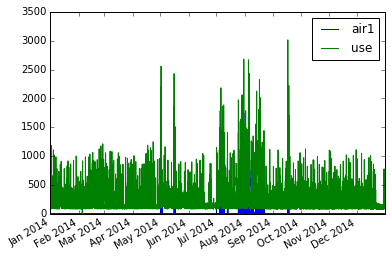

In [36]:
st['/3938'][['air1','use']]['2014'].plot()

3938 was hardly used! 

In [47]:
%matplotlib inline

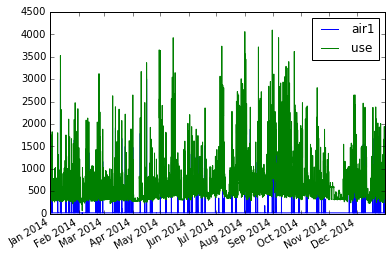

In [49]:
st['/7062'][['air1','use']]['2014'].plot()

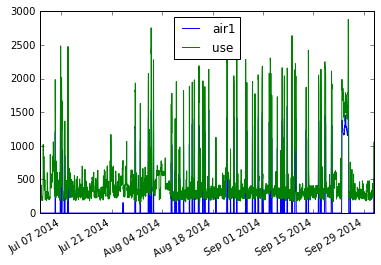

In [187]:
st['/6377'][['air1','use']]['7-1-2014':'10-1-2014'].plot()

7062 has very less usgae and maybe is some data error. Should be removed from analysis!

In [ ]:
5938- Put np.NaN on 8th month
7062-  Exclude from set of homes
3938- Put np.NaN on 9th month
4495- Hardly used. Exclude from set of home


In [96]:
df[['fridge_6', 'fridge_7','fridge_8','fridge_9']]

,fridge_6,fridge_7,fridge_8,fridge_9
54,37.451565,37.834301,38.103199,28.727217
203,48.030052,56.448948,44.765385,39.742134
1450,65.856636,72.587753,54.018948,52.222767
1731,40.344700,44.515667,45.955036,42.599567
2354,NaN,NaN,NaN,NaN
2606,NaN,NaN,NaN,NaN
3687,133.440353,140.171219,138.987930,130.501511
3864,37.346516,42.800053,41.861118,41.774750
3938,36.528286,47.456169,42.763733,41.923233
4083,32.956615,36.872147,39.073502,29.292915


In [104]:
mean_across_months['hvac']

54      70.351715
203     73.487913
1450    93.183348
1731    88.232076
2354    91.339274
2606    85.306774
3687    88.025764
3864    82.360212
3938    34.987982
4083    69.889387
4095    81.260906
4934    75.331385
5938    80.124602
6377    76.126821
6429    59.028287
6547    86.827769
7114    79.389577
7409    86.107839
7639    55.726624
8061    99.480434
8342    41.419973
8574    88.827247
8733    88.928077
9213    72.547406
9370    81.126097
9585    64.770109
9612    93.811794
9775    76.109404
dtype: float64

In [154]:
df

,aggregate_7,aggregate_8,aggregate_9,hvac_7,hvac_8,hvac_9,fridge_7,fridge_8,fridge_9,dw_7,dw_8,dw_9,mw_7,mw_8,mw_9
54,0.265679,0.275405,0.167601,149.310196,158.417160,120.083450,37.834301,38.103199,28.727217,15.490267,14.173583,8.487300,7.218117,2.903950,1.892617
203,0.490503,0.397438,0.275920,258.869934,232.730652,174.584366,56.448948,44.765385,39.742134,0.599217,0.000667,0.545717,11.203717,9.830317,7.555984
1450,0.700644,0.935066,0.863948,296.445068,454.090759,469.634796,72.587753,54.018948,52.222767,19.510000,22.250017,19.913500,19.398167,26.427166,14.663067
1731,0.619553,0.627770,0.787347,289.619293,305.011932,390.342133,44.515667,45.955036,42.599567,4.947166,4.171333,5.398050,5.765916,6.296000,6.078183
2354,0.665513,0.595442,0.668042,350.511749,297.995850,309.096863,NaN,NaN,NaN,19.126434,18.484699,17.355982,22.555834,22.376900,18.119551
2606,0.461168,0.516959,0.629680,286.592285,325.527496,420.435608,NaN,NaN,NaN,1.254200,1.269933,4.077816,5.274633,4.384900,5.024533
3687,0.647967,0.654803,0.528025,289.946289,325.588562,266.525909,140.171219,138.987930,130.501511,1.760717,2.865600,2.854317,9.029433,8.242017,5.396533
3864,0.176759,0.261287,0.385050,125.890953,202.170044,321.311798,42.800053,41.861118,41.774750,1.233067,4.648983,2.413567,6.309617,6.110567,6.289217
3938,0.128743,0.110832,0.025573,61.706448,68.106033,7.287033,47.456169,42.763733,41.923233,18.806967,15.715583,10.026850,6.196917,4.669850,2.803300
4083,0.068033,0.055248,0.005281,66.353279,47.636971,43.062366,36.872147,39.073502,29.292915,1.185167,1.682917,0.555567,0.610317,0.632183,0.664283


In [165]:
acc = {}
for appliance in ["hvac"]:
    if appliance in acc:
        continue
    else:
        print appliance
        acc[appliance] = {}
        feature="Monthly+Static"
        for home in all_homes[appliance][:]:
            try:
                pred, gt, out_df = _find_accuracy(home, appliance, feature)
                acc[appliance][home]=out_df
                print home, acc[appliance][home].mean()
            except Exception, e:
                print e

hvac
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
203 92.8228097179
1450 80.4178943504
1731 85.1328778421
2354 82.4284199212
2606 83.4957909455
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
3864 52.2943539549
3938 88.1533168571
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
4934 1.54071277141
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
6547 89.4081050863
7114 42.3853383249
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
8061 85.0545684025
8574 36.6546001835
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 i

In [169]:
pd.Series(acc['hvac']).mean()

66.94547434568446

In [173]:
import sys
sys.path.append("../code/")
from common_functions import tableau20blind, format_axes

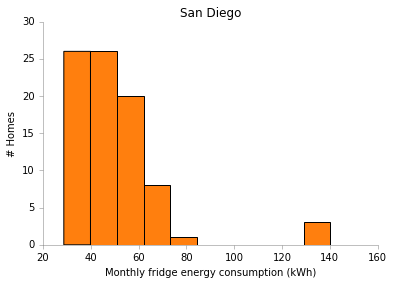

In [175]:
pd.Series(df[['fridge_7','fridge_8','fridge_9']].dropna().values.flatten()).hist(color=tableau20blind[2])
plt.grid(False)
format_axes(plt.gca())
plt.xlabel("Monthly fridge energy consumption (kWh)")
plt.title("San Diego")
plt.ylabel("# Homes")
plt.savefig("../results/sd_fridge_hist.png")